# Tensorflow for autoencoder

In [1]:
# load library
import os
import sys

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

import tensorflow as tf

PROJECT_ROOT_DIR = "."
ID = "autoencoders"

In [2]:
# utility functions
# save figures
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multi_images(images, n_rows, n_cols, pad=2):
    images -= images.min()
    w, h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad) * n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(w+pad)+pad):(y*(w+pad)+pad+h), (x*(h+pad)+pad):(x*(h+pad)+pad+h)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## PCA with a linear Autoencoder

In [3]:
# 3D dataset
np.random.seed(2017)
m = 100
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X_train = np.empty((m, 3))
X_train[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X_train[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X_train[:, 2] = X_train[:, 0] * w1 + X_train[:, 1] * w2 + noise * np.random.randn(m)

In [4]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [5]:
# PCA
tf.reset_default_graph()

n_inputs = 3
n_hidden = 2 # encoder
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, [None, n_inputs])
h = tf.layers.dense(X, n_hidden, activation=None)  # linear transform
outputs = tf.layers.dense(h, n_outputs, activation=None)

mse_loss = tf.reduce_mean(tf.square(X - outputs))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(mse_loss)
init = tf.global_variables_initializer()

In [6]:
n_epochs = 10000

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        _, mse = sess.run([train_op, mse_loss], feed_dict={X: X_train})
        if epoch % 1000 == 0:
            print("Epoch", epoch, "mse:", mse)
    encoded_output = sess.run(h, feed_dict={X: X_train})

Epoch 0 mse: 1.77635
Epoch 1000 mse: 0.0443353
Epoch 2000 mse: 0.043948
Epoch 3000 mse: 0.0439479
Epoch 4000 mse: 0.0439479
Epoch 5000 mse: 0.0439501
Epoch 6000 mse: 0.043948
Epoch 7000 mse: 0.043948
Epoch 8000 mse: 0.043948
Epoch 9000 mse: 0.0439479


Saving figure linear_autoencoder_pca_plot


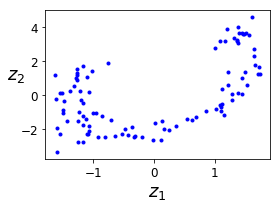

In [7]:
# plot
fig = plt.figure(figsize=(4,3))
plt.plot(encoded_output[:,0], encoded_output[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders

In [8]:
# mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Train all layers at once

In [9]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150  # encoding
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 1e-4

dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, 
                     kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

X = tf.placeholder(tf.float32, [None, n_inputs])

h1 = dense_layer(X, n_hidden1)
h2 = dense_layer(h1, n_hidden2)
h3 = dense_layer(h2, n_hidden3)
outputs = dense_layer(h3, n_outputs, activation=None)

mse_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([mse_loss] + reg_loss)

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
n_epochs = 5
batch_size = 128
num_batch = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for t in range(num_batch):
            X_batch, _ = mnist.train.next_batch(batch_size)
            _, mse_train = sess.run([train_op, mse_loss], feed_dict={X: X_batch})
        print("Epoch", epoch, "mse:", mse_train)
    saver.save(sess, "./tmp/my_model_all_layers.ckpt")

Epoch 0 mse: 0.0240489
Epoch 1 mse: 0.0128124
Epoch 2 mse: 0.0118014
Epoch 3 mse: 0.0113695
Epoch 4 mse: 0.0111495


In [11]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./tmp/my_model_all_layers.ckpt
Saving figure reconstruction_plot


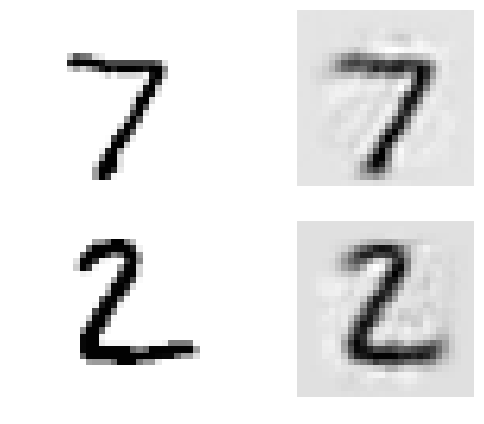

In [12]:
show_reconstructed_digits(X, outputs, "./tmp/my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

### Tying weigts

In [13]:
tf.reset_default_graph()

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])

W1 = tf.Variable(initializer([n_inputs, n_hidden1]), dtype=tf.float32, name="W1")
b1 = tf.Variable(tf.zeros([n_hidden1,]), name="b1")
W2 = tf.Variable(initializer([n_hidden1, n_hidden2]), dtype=tf.float32, name="W2")
b2 = tf.Variable(tf.zeros([n_hidden2,]), name="b2")
W3 = tf.transpose(W2, name="W3")
b3 = tf.Variable(tf.zeros([n_hidden3,]), name="b3")
W4 = tf.transpose(W1, name="W4")
b4 = tf.Variable(tf.zeros([n_outputs,]), name="b4")

h1 = activation(tf.nn.xw_plus_b(X, W1, b1))
h2 = activation(tf.nn.xw_plus_b(h1, W2, b2))
h3 = activation(tf.nn.xw_plus_b(h2, W3, b3))
outputs = tf.nn.xw_plus_b(h3, W4, b4)

mse_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(W1) + regularizer(W2)
loss = mse_loss + reg_loss

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_epochs = 5
batch_size = 128
num_batch = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for t in range(num_batch):
            X_batch, _ = mnist.train.next_batch(batch_size)
            _, mse_train = sess.run([train_op, mse_loss], feed_dict={X: X_batch})
        print("Epoch", epoch, "mse:", mse_train)
    saver.save(sess, "./tmp/my_model_all_layers_tying.ckpt")

Epoch 0 mse: 0.0112707
Epoch 1 mse: 0.00796578
Epoch 2 mse: 0.00771752
Epoch 3 mse: 0.00727718
Epoch 4 mse: 0.00726337


INFO:tensorflow:Restoring parameters from ./tmp/my_model_all_layers_tying.ckpt
Saving figure reconstruction_plot2


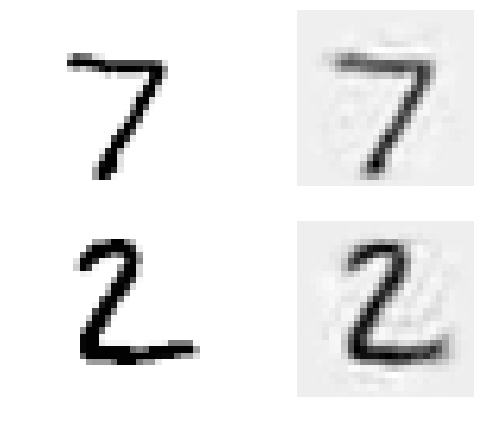

In [15]:
show_reconstructed_digits(X, outputs, "./tmp/my_model_all_layers_tying.ckpt")
save_fig("reconstruction_plot2")

### Training one Autoencoder at a time in multiple graphs

In [16]:
# a graph for a layer
def train_autoencoder_layer(inpt, n_units, n_epochs, batch_size, learning_rate = 0.01, 
                            l2_reg = 0.0005, activation=tf.nn.elu, initializer=tf.contrib.layers.variance_scaling_initializer()):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = inpt.shape[1]
        regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
        X = tf.placeholder(tf.float32, [None, n_inputs])
        
        h = tf.layers.dense(X, n_units, activation=activation, name="hidden", kernel_initializer=initializer,
                           kernel_regularizer=regularizer)
        outputs = tf.layers.dense(h, n_inputs, activation=None, name="outputs", kernel_initializer=initializer,
                           kernel_regularizer=regularizer)
        
        mse_loss = tf.reduce_mean(tf.square(outputs - X))
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([mse_loss] + reg_loss)
        
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        init = tf.global_variables_initializer()
    
    with tf.Session(graph=graph) as sess:
        num_batch = len(inpt) // batch_size
        sess.run(init)
        for epoch in range(n_epochs):
            for t in range(num_batch):
                indices = np.random.permutation(len(inpt))[:batch_size]
                X_batch = inpt[indices]
                _, mse_train = sess.run([train_op, mse_loss], feed_dict={X: X_batch})
            print("Epoch", epoch, "mse:", mse_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        h_val = h.eval(feed_dict={X: inpt})
        return h_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [17]:
hidden_output, W1, b1, W4, b4 = train_autoencoder_layer(mnist.train.images, n_units=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder_layer(hidden_output, n_units=150, n_epochs=4, batch_size=150)

Epoch 0 mse: 0.0189829
Epoch 1 mse: 0.0184789
Epoch 2 mse: 0.0191758
Epoch 3 mse: 0.0191016
Epoch 0 mse: 0.00448945
Epoch 1 mse: 0.00456623
Epoch 2 mse: 0.00490648
Epoch 3 mse: 0.00482273


In [18]:
# stack 
tf.reset_default_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

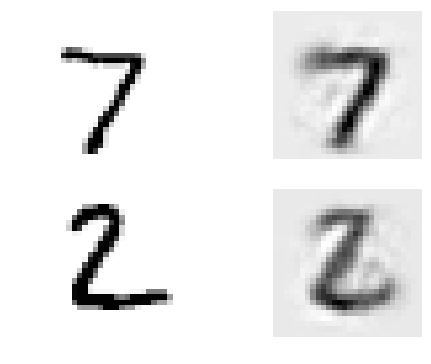

In [19]:
show_reconstructed_digits(X, outputs)

### Training one Autoencoder at a time in a single graph (Tying Weights)

In [56]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150  # encoding
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 1e-5

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])

W1 = tf.Variable(initializer([n_inputs, n_hidden1]), dtype=tf.float32, name="W1")
b1 = tf.Variable(tf.zeros([n_hidden1,]), name="b1")
W2 = tf.Variable(initializer([n_hidden1, n_hidden2]), dtype=tf.float32, name="W2")
b2 = tf.Variable(tf.zeros([n_hidden2,]), name="b2")
W3 = tf.transpose(W2, name="W3")
b3 = tf.Variable(tf.zeros([n_hidden3,]), name="b3")
W4 = tf.transpose(W1, name="W4")
b4 = tf.Variable(tf.zeros([n_outputs,]), name="b4")

h1 = activation(tf.nn.xw_plus_b(X, W1, b1))
h2 = activation(tf.nn.xw_plus_b(h1, W2, b2))
h3 = activation(tf.nn.xw_plus_b(h2, W3, b3))
outputs = tf.nn.xw_plus_b(h3, W4, b4)

with tf.name_scope("layer1"):
    layer1_outputs = tf.nn.xw_plus_b(h1, W4, b4)
    layer1_mse = tf.reduce_mean(tf.square(layer1_outputs - X))
    layer1_loss = layer1_mse + regularizer(W1)
    layer1_train_op = tf.train.AdamOptimizer(learning_rate).minimize(layer1_loss, var_list=[W1, b1, b4])

with tf.name_scope("layer2"):
    layer2_mse = tf.reduce_mean(tf.square(h3 - h1))
    layer2_loss = layer2_mse + regularizer(W2)
    layer2_train_op = tf.train.AdamOptimizer(learning_rate).minimize(layer2_loss, var_list=[W2, b2, b3])
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [57]:
training_ops = [layer1_train_op, layer2_train_op]
mses = [layer1_mse, layer2_mse]
n_epochs = [5, 5]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for layer in range(2):
        print("Training layer #{}".format(layer + 1))
        if layer == 1:
            mnist_hidden1 = h1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[layer]):
            n_batches = mnist.train.num_examples // batch_sizes[layer]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if layer == 1:
                    indices = np.random.permutation(len(mnist_hidden1))
                    hidden1_batch = mnist_hidden1[indices[:batch_sizes[layer]]]
                    feed_dict = {h1: hidden1_batch}
                    sess.run(training_ops[layer], feed_dict=feed_dict)
                else:
                    X_batch, _ = mnist.train.next_batch(batch_sizes[layer])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[layer], feed_dict=feed_dict)
            mse_train = mses[layer].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    mse_test = mses[layer].eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", mse_test)

Training layer #1
0 Train MSE: 0.00377009
1 Train MSE: 0.00223285
2 Train MSE: 0.00165447
3 Train MSE: 0.00153537
49% Train MSE: 0.00142765
Training layer #2
0 Train MSE: 0.0172365
19% Train MSE: 0.00936307
2 Train MSE: 0.00732472
3 Train MSE: 0.00654762
49% Train MSE: 0.00575416
Test MSE: 0.00601665


INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt


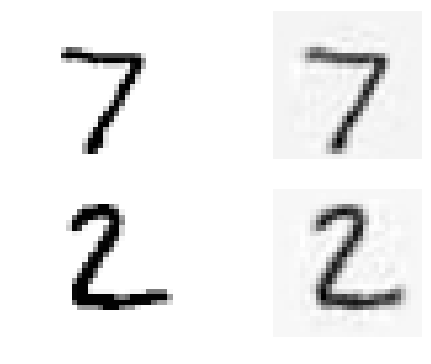

In [58]:
show_reconstructed_digits(X, outputs, "./my_model_cache_frozen.ckpt")

## Unsupervised pretraining for mnist

In [59]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 5e-4

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])
y = tf.placeholder(tf.int32, [None])

W1 = tf.Variable(initializer([n_inputs, n_hidden1]), dtype=tf.float32, name="W1")
b1 = tf.Variable(tf.zeros([n_hidden1,]), name="b1")
W2 = tf.Variable(initializer([n_hidden1, n_hidden2]), dtype=tf.float32, name="W2")
b2 = tf.Variable(tf.zeros([n_hidden2,]), name="b2")
W3 = tf.Variable(initializer([n_hidden2, n_outputs]), dtype=tf.float32, name="W3")
b3 = tf.Variable(tf.zeros([n_outputs,]), name="b3")

h1 = activation(tf.nn.xw_plus_b(X, W1, b1))
h2 = activation(tf.nn.xw_plus_b(h1, W2, b2))
logits = tf.nn.xw_plus_b(h2, W3, b3)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
reg_loss = regularizer(W1) + regularizer(W2) + regularizer(W3)
loss = reg_loss + tf.reduce_mean(cross_entropy)

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([W1, W2, b1, b2])
saver = tf.train.Saver()

In [60]:
# regular training
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.953333 Test accuracy: 0.9358
1 Train accuracy: 0.993333 Test accuracy: 0.9469
29% Train accuracy: 0.973333 Test accuracy: 0.9476
3 Train accuracy: 0.973333 Test accuracy: 0.9323


In [61]:
## with pretraining
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.926667	Test accuracy: 0.9125
19% Train accuracy: 0.966667	Test accuracy: 0.939
2 Train accuracy: 0.98	Test accuracy: 0.9249
3 Train accuracy: 0.966667	Test accuracy: 0.9286


## Stacked denoising autoencoder

In [63]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 1e-5
dropout_rate = 0.3

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])
is_training = tf.placeholder_with_default(False, shape=[], name="is_training")
X_drop = tf.layers.dropout(X, dropout_rate, training=is_training)

W1 = tf.Variable(initializer([n_inputs, n_hidden1]), dtype=tf.float32, name="W1")
b1 = tf.Variable(tf.zeros([n_hidden1,]), name="b1")
W2 = tf.Variable(initializer([n_hidden1, n_hidden2]), dtype=tf.float32, name="W2")
b2 = tf.Variable(tf.zeros([n_hidden2,]), name="b2")
W3 = tf.transpose(W2, name="W3")
b3 = tf.Variable(tf.zeros([n_hidden3,]), name="b3")
W4 = tf.transpose(W1, name="W4")
b4 = tf.Variable(tf.zeros([n_outputs,]), name="b4")

h1 = activation(tf.nn.xw_plus_b(X_drop, W1, b1))
h2 = activation(tf.nn.xw_plus_b(h1, W2, b2))
h3 = activation(tf.nn.xw_plus_b(h2, W3, b3))
outputs = tf.nn.xw_plus_b(h3, W4, b4)

mse_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(W1) + regularizer(W2)
loss = mse_loss + reg_loss

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [64]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X: X_batch, is_training: True})
        mse_train = mse_loss.eval(feed_dict={X: X_batch, is_training: False})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_stacked_denoising.ckpt")

0 Train MSE: 0.0188708
1 Train MSE: 0.0135786
29% Train MSE: 0.0113397
3 Train MSE: 0.010279
4 Train MSE: 0.00961263
5 Train MSE: 0.00885574
69% Train MSE: 0.00939195
7 Train MSE: 0.00923494
8 Train MSE: 0.00853442
9 Train MSE: 0.0090277


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising.ckpt


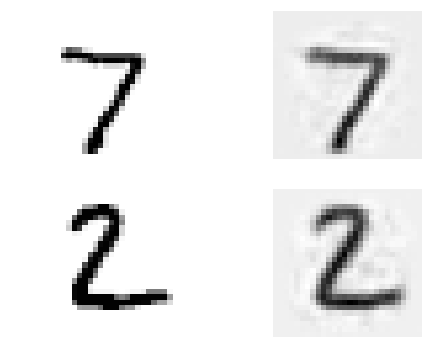

In [65]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising.ckpt")

### Visualizing the extracted features

In [67]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_stacked_denoising.ckpt")
    W1_val = W1.eval()

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising.ckpt


Saving figure extracted_features_plot


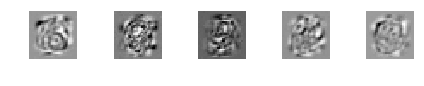

In [70]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_image(W1_val.T[i])

save_fig("extracted_features_plot")
plt.show()

## Sparse Autoencoder

d:\anaconda3\envs\tf_new\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Saving figure sparsity_loss_plot


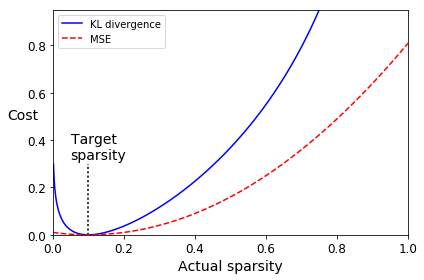

In [71]:
p = 0.1
q = np.linspace(0, 1, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [72]:
# KL divergence
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [76]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden = 1000  # sparse coding
n_outputs = n_inputs

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

activation = tf.nn.sigmoid
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])

W1 = tf.Variable(initializer([n_inputs, n_hidden]), dtype=tf.float32, name="W1")
W2 = tf.Variable(initializer([n_hidden, n_outputs]), dtype=tf.float32, name="W2")
b1 = tf.Variable(tf.zeros([n_hidden,]), name="b1")
b2 = tf.Variable(tf.zeros([n_outputs,]), name="b2")

h1 = activation(tf.nn.xw_plus_b(X, W1, b1))
outputs = tf.nn.xw_plus_b(h1, W2, b2)

mse_loss = tf.reduce_mean(tf.square(outputs - X))
sparsity_loss = tf.reduce_mean(kl_divergence(sparsity_target, tf.reduce_mean(h1, axis=0)))
loss = mse_loss + sparsity_weight * sparsity_loss

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X: X_batch})
        mse_val, sparsity_loss_val, loss_val = sess.run([mse_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.089448 	Sparsity loss: 0.31594 	Total loss: 0.152636
1 Train MSE: 0.0798196 	Sparsity loss: 0.301433 	Total loss: 0.140106
2 Train MSE: 0.0702621 	Sparsity loss: 0.307248 	Total loss: 0.131712
3 Train MSE: 0.072368 	Sparsity loss: 0.263305 	Total loss: 0.125029
4 Train MSE: 0.0658286 	Sparsity loss: 0.231783 	Total loss: 0.112185
5 Train MSE: 0.0573753 	Sparsity loss: 0.152271 	Total loss: 0.0878295
6 Train MSE: 0.0461967 	Sparsity loss: 0.091913 	Total loss: 0.0645794
7 Train MSE: 0.0323527 	Sparsity loss: 0.0477101 	Total loss: 0.0418947
8 Train MSE: 0.0224417 	Sparsity loss: 0.0230307 	Total loss: 0.0270478
9 Train MSE: 0.0169484 	Sparsity loss: 0.014174 	Total loss: 0.0197832
10 Train MSE: 0.0135708 	Sparsity loss: 0.00927507 	Total loss: 0.0154258
11 Train MSE: 0.0115894 	Sparsity loss: 0.0081538 	Total loss: 0.0132201
12 Train MSE: 0.0103312 	Sparsity loss: 0.00816472 	Total loss: 0.0119641
13 Train MSE: 0.00917437 	Sparsity loss: 0.00835424 	Total loss: 0.0108452


INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


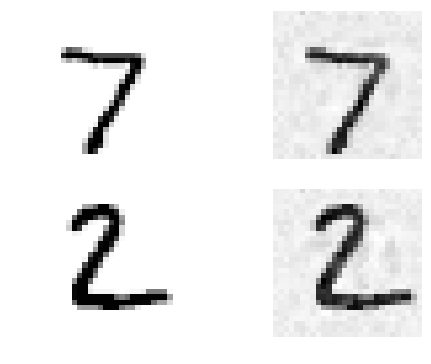

In [78]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

## Variational Autoencoder

In [84]:
from functools import partial

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20   # latent coding
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 1e-3

dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, 
                      kernel_initializer=tf.contrib.layers.variance_scaling_initializer())

X = tf.placeholder(tf.float32, [None, n_inputs])

h1 = dense_layer(X, n_hidden1)
h2 = dense_layer(h1, n_hidden2)
h3_mean = dense_layer(h2, n_hidden3, activation=None)
h3_log_gamma = dense_layer(h2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(h3_mean), dtype=tf.float32)
h3 = h3_mean + noise * tf.exp(0.5 * h3_log_gamma)
h4 = dense_layer(h3, n_hidden4)
h5 = dense_layer(h4, n_hidden5)
logits = dense_layer(h5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(h3_log_gamma) + tf.square(h3_mean) - 1 - h3_log_gamma)
loss = reconstruction_loss + latent_loss

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [85]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X: X_batch})
        cost_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train cost:", cost_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train cost: 17875.2 	Reconstruction loss: 14240.6 	Latent loss: 3634.61
19% Train cost: 17548.1 	Reconstruction loss: 13777.4 	Latent loss: 3770.78
2 Train cost: 17034.8 	Reconstruction loss: 13168.9 	Latent loss: 3865.9
39% Train cost: 16482.2 	Reconstruction loss: 12694.2 	Latent loss: 3788.05
49% Train cost: 16032.7 	Reconstruction loss: 12276.8 	Latent loss: 3755.82
5 Train cost: 15633.8 	Reconstruction loss: 11945.7 	Latent loss: 3688.03
6 Train cost: 15861.8 	Reconstruction loss: 12043.6 	Latent loss: 3818.26
7 Train cost: 16033.8 	Reconstruction loss: 12243.4 	Latent loss: 3790.37
8 Train cost: 15669.4 	Reconstruction loss: 11919.0 	Latent loss: 3750.39
9 Train cost: 15610.7 	Reconstruction loss: 11797.2 	Latent loss: 3813.54
10 Train cost: 15734.4 	Reconstruction loss: 12052.3 	Latent loss: 3682.09
11 Train cost: 15623.2 	Reconstruction loss: 11804.1 	Latent loss: 3819.05
12 Train cost: 15977.3 	Reconstruction loss: 12092.2 	Latent loss: 3885.17
13 Train cost: 15843.5 	Recons

In [86]:
# encode
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = h3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [87]:
# decode
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


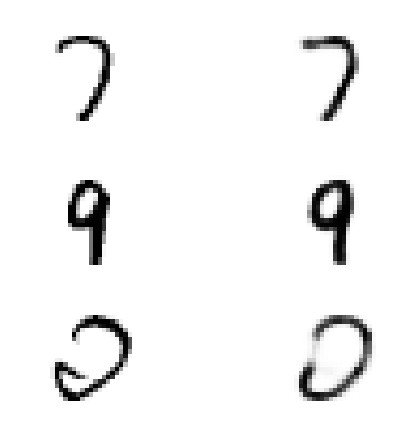

In [88]:
# plot the reconstructions
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

### Generate digits

In [89]:
n_rows = 6
n_cols = 10
n_digits = n_rows * n_cols
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_rnd})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Saving figure generated_digits_plot


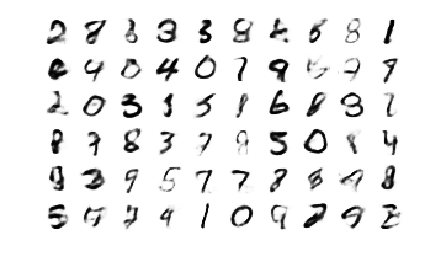

In [91]:
plot_multi_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("generated_digits_plot")
plt.show()

### Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


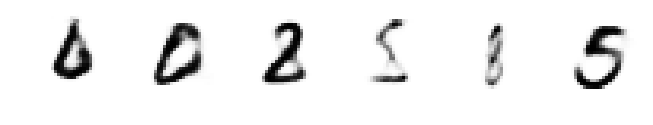

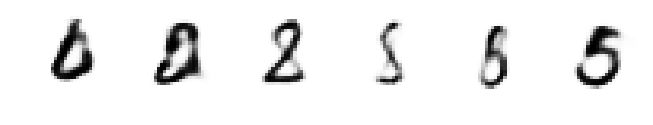

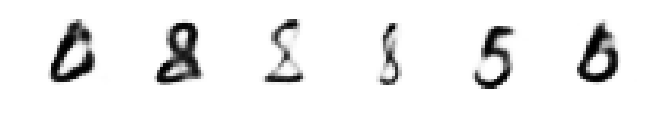

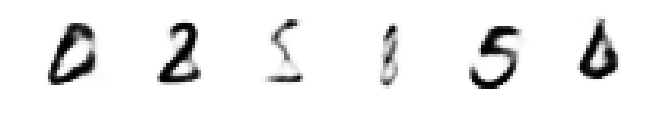

In [93]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()